In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os as os
from tslearn.clustering import TimeSeriesKMeans
import seaborn as sns

In [2]:
# read data from files and construct dataframe and clean (replace nan produced with 0's, transpose, truncate extra columns of 0's )
# zero padding is done from day of conception

folder_paths= ["C:/Users/Soft/script_aqil/Procedural history until term MRI scan - NaN removed/No NaN in painful procedures/",
               "C:/Users/Soft/script_aqil/Procedural history until term MRI scan - NaN removed/Nan replaced - incomplete in-patient painful procedures/",
               "C:/Users/Soft/script_aqil/Procedural history until term MRI scan - NaN removed/Nan replaced - added post discharge IM_d5 lance/"]
data_dic= {}
ga_dic= {}

for folder_path in folder_paths:
    names= os.listdir(folder_path)
    filenames= [x for x in names if x.endswith('.xlsx')]


    for i in filenames:

        pain= pd.read_excel(folder_path+i, sheet_name="PAIN BURDEN_MEAN SCORE")[['PNA', 'PAIN BURDEN']]
        pain= pd.DataFrame(pain)
        pain.dropna(axis=0, inplace=True)

        admission= pd.read_excel(folder_path+i, sheet_name="ADMISSION").iloc[:,:2]
        weeks= admission.loc[admission.iloc[:,0]== 'GA,weeks'].values[0][1]
        days= admission.loc[admission.iloc[:,0]== 'GA,days'].values[0][1]
        ga= weeks*7+days
    
        z=pd.DataFrame(np.zeros((ga,2)), columns= ['PNA', 'PAIN BURDEN'])
        pain_profile= pd.concat([z,pain], axis=0, ignore_index= True)
        j= i.replace('_procedure history_V6c3.xlsx','')
        j= j.replace('_procedure history_V63.xlsx','')
        data_dic[j]= pain_profile['PAIN BURDEN']
        ga_dic[j]= ga
df= pd.DataFrame(data_dic)
df.fillna(0,inplace=True)
# dataframe transposed to have the individual observations in rows and days in columns
df= df.T
# subset data (truncates), from first non-zero column to the last    
start= min(np.nonzero(np.array(df))[1])
end= max(np.nonzero(np.array(df))[1])
df_trunc= df.iloc[:,start:end+1]
# construct dataframe to store gestational age of each individual    
ga_df= pd.DataFrame(ga_dic.items(), columns=['id', 'gestational_age'])
ga_df.set_index('id', inplace=True)

In [3]:
# smoothening using different windows on different bins according to number of days of pain record

records={}
for i in range(df.shape[0]):
    s= df.iloc[i,:]
    non_zero= len(np.nonzero(np.array(s))[0])
    records[df.index[i]]= non_zero  
    records[df.index[i]]= non_zero 
    
procedures= pd.DataFrame(records.items(), columns= ['id', 'procedures'])
procedures.set_index('id', inplace=True)

# have 0's infront to compensate for loss of observations discarded infront
df_for_moving_avg= df.iloc[:,start-3:end+4]

# subset dataset according to number of procedures and apply moving average function over them
window_1= df_for_moving_avg[procedures.procedures<=15]
window_2= df_for_moving_avg[(procedures.procedures>15) & (procedures.procedures<=35)]
window_2= window_2.rolling(window=3, center= True, axis= 1).mean()
window_3= df_for_moving_avg[(procedures.procedures>35) & (procedures.procedures<=100)]
window_3= window_3.rolling(window=4, center= True, axis= 1).mean()
window_4= df_for_moving_avg[(procedures.procedures>100)]
window_4= window_4.rolling(window=6, center= True, axis= 1).mean()

# combine the subsets into one dataframe
df_ma= pd.concat([window_1,window_2,window_3,window_4])
# arrange index as in the previous dataset
df_ma= df_ma.reindex(df_for_moving_avg.index)

# replace nan with 0
df_ma.fillna(0, inplace=True)

# truncate columns of 0's occurred as result of introduction of nan values
start_ma= min(np.nonzero(np.array(df_ma))[1])
end_ma= max(np.nonzero(np.array(df_ma))[1])
df_ma= df_ma.iloc[:,start_ma:end_ma+1]

In [4]:
# limits of x and y axes
x_max= df_ma.shape[1]
y_max= df_ma.max().max()
start_day= df_ma.columns[0]

### K means clustering

In [5]:
# split data according to age at birth
# <28 weeks (<196 days): extremely preterm
# 28-32 weeks (196-224 days): very preterm
# >32 weeks (>224 days): moderate to late preterm

extreme= df_ma[ga_df.gestational_age<=196]
ga_df_extreme= ga_df.loc[list(extreme.index),:]
very= df_ma[(ga_df.gestational_age>196) & (ga_df.gestational_age<=224)]
ga_df_very= ga_df.loc[list(very.index),:]
moderate= df_ma[ga_df.gestational_age>224]
ga_df_moderate= ga_df.loc[list(moderate.index),:]

for subset, subset_name in zip([extreme, very, moderate], ["Extreme", "Very", "Moderate"]):
    print('%s preterm has %d samples' %(subset_name, subset.shape[0] ))

Extreme preterm has 8 samples
Very preterm has 10 samples
Moderate preterm has 35 samples


In [6]:
# truncate excess 0's in very preterm and moderately preterm age group

start_very= min(np.nonzero(np.array(very))[1])
end_very= max(np.nonzero(np.array(very))[1])
very_trunc= very.iloc[:,start_very:end_very+1]

start_moderate= min(np.nonzero(np.array(moderate))[1])
end_moderate= max(np.nonzero(np.array(moderate))[1])
moderate_trunc= moderate.iloc[:,start_moderate:end_moderate+1]

In [7]:
# function to obtain minimum, maximum and mean gestatinal ages for each cluster
def ga_stats_gen(y_pred, n_clus, ga_df):
    min_ga, max_ga, mean_ga =[], [], []
    for i in range(n_clus):
        c_ga= ga_df[y_pred==i]
        min_ga.append(min(c_ga['gestational_age']))
        max_ga.append(max(c_ga['gestational_age']))
        mean_ga.append(np.mean(c_ga['gestational_age']))
    df= pd.DataFrame({'min_ga':min_ga, 'max_ga':max_ga, 'mean_ga':mean_ga})
    return df

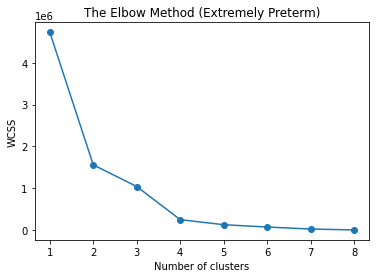

In [8]:
# extremely preterm
# elbow method to find optimal number of clusters
wcss=[]
for i in range(1,10):
    dba_elbow=  TimeSeriesKMeans(n_clusters=i,
                          n_init=3,
                          metric="dtw",
                          metric_params = {'sakoe_chiba_radius':7},       
                          max_iter_barycenter=10,
                          random_state=13)
    dba_elbow.fit(extreme)
    wcss.append(dba_elbow.inertia_)
plt.plot(range(1, 10), wcss, marker='o')
plt.title('The Elbow Method (Extremely Preterm)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Optimum number of clusters is 2

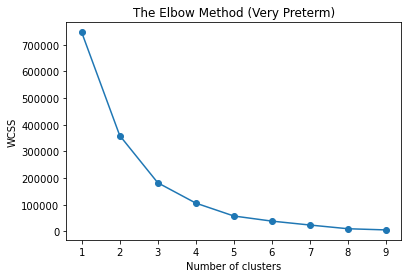

In [9]:
# very preterm (truncated)
# elbow method to find optimal number of clusters
wcss=[]
for i in range(1,10):
    dba_elbow=  TimeSeriesKMeans(n_clusters=i,
                          n_init=3,
                          metric="dtw",
                          metric_params = {'sakoe_chiba_radius':7},       
                          max_iter_barycenter=10,
                          random_state=13)
    dba_elbow.fit(very_trunc)
    wcss.append(dba_elbow.inertia_)
plt.plot(range(1, 10), wcss, marker='o')
plt.title('The Elbow Method (Very Preterm)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Optimum number of clusters is 3

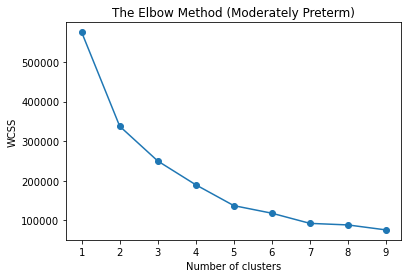

In [10]:
# moderately preterm (truncated)
# elbow method to find optimal number of clusters
wcss=[]
for i in range(1,10):
    dba_elbow=  TimeSeriesKMeans(n_clusters=i,
                          n_init=3,
                          metric="dtw",
                          metric_params = {'sakoe_chiba_radius':7},       
                          max_iter_barycenter=10,
                          random_state=13)
    dba_elbow.fit(moderate_trunc)
    wcss.append(dba_elbow.inertia_)
plt.plot(range(1, 10), wcss, marker='o')
plt.title('The Elbow Method (Moderately Preterm)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Optimum number of clusters is 5

In [11]:
# training models for the 3 age groups (according to their optimal number of clusters)

# create dataframe to store mean gestational age for each cluster
clus_wise_index=[]
clus_mean_ga={}

n_cluss= [2,3,5]
# extremely preterm
n_clus_extreme= n_cluss[0]
dba_km_extreme = TimeSeriesKMeans(n_clusters=n_clus_extreme,
                          n_init=3,
                          metric="dtw",
                          metric_params = {'sakoe_chiba_radius':7},
                          max_iter_barycenter=10,
                          random_state=13)
y_pred_extreme = dba_km_extreme.fit_predict(extreme)
ga_stats_extreme= ga_stats_gen(y_pred_extreme, n_clus_extreme, ga_df_extreme)
for i in range(n_clus_extreme):
    clus_wise_index.append(extreme[y_pred_extreme==i].index)
    clus_mean_ga[i+1]= ga_stats_extreme.mean_ga[i]

# very preterm
n_clus_very= n_cluss[1]
dba_km_very = TimeSeriesKMeans(n_clusters=n_clus_very,
                          n_init=3,
                          metric="dtw",
                          metric_params = {'sakoe_chiba_radius':7},
                          max_iter_barycenter=10,
                          random_state=13)
y_pred_very = dba_km_very.fit_predict(very_trunc)
ga_stats_very= ga_stats_gen(y_pred_very, n_clus_very, ga_df_very)
for i in range(n_clus_very):
    clus_wise_index.append(very[y_pred_very==i].index)
    clus_mean_ga[n_clus_extreme+i+1]= ga_stats_very.mean_ga[i]

# moderate to late preterm
n_clus_moderate= n_cluss[2]
dba_km_moderate = TimeSeriesKMeans(n_clusters=n_clus_moderate,
                          n_init=3,
                          metric="dtw",
                          metric_params = {'sakoe_chiba_radius':7},
                          max_iter_barycenter=10,
                          random_state=13)
y_pred_moderate = dba_km_moderate.fit_predict(moderate_trunc)
ga_stats_moderate= ga_stats_gen(y_pred_moderate, n_clus_moderate, ga_df_moderate)
for i in range(n_clus_moderate):
    clus_wise_index.append(moderate[y_pred_moderate==i].index)
    clus_mean_ga[n_clus_extreme+n_clus_very+i+1]= ga_stats_moderate.mean_ga[i]

# make lists of models, data, and ga_df to iterate when plotting all clusters
models= [dba_km_extreme, dba_km_very, dba_km_moderate]
data= [extreme, very_trunc, moderate_trunc]
ga_dfs= [ga_df_extreme, ga_df_very, ga_df_moderate]

# list of offset from initial dataset for each age group as a result of truncation
offsets=[0, start_very, start_moderate]


In [12]:
# sort clusters in ascending order of mean Gestational Age
clus_mean_ga_df= pd.DataFrame(clus_mean_ga.items(), 
                              columns=['cluster', 'mean_ga']).sort_values(axis=0,by=['mean_ga'],ignore_index= True)

# Create dictionary with ID and Cluster label, grouped by cluster, clusters sorted in ascedning order of mean GA
clus_label={}
for i in range(clus_mean_ga_df.shape[0]):
    index_cluster_i =clus_mean_ga_df.cluster[i]-1
    index_list= list(clus_wise_index[index_cluster_i])
    for j in range(len(index_list)):
        clus_label[index_list[j]]= i+1
        
# create dataframe with subject ID, Cluster label and GA
clus_label_df= pd.DataFrame(clus_label.items(), columns=['id', 'cluster'])
clus_label_df.set_index('id', inplace= True)
clus_label_df= clus_label_df.join(ga_df)
clus_label_df.rename(columns={'gestational_age': 'ga_days'}, inplace= True)
clus_label_df['ga_weeks']= np.round(clus_label_df.ga_days/7,2)

C:\Users\Soft\AppData\Local\Temp\ipykernel_17580\3892034977.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clusters.append(df_ma[clus_label_df.cluster==i+1])


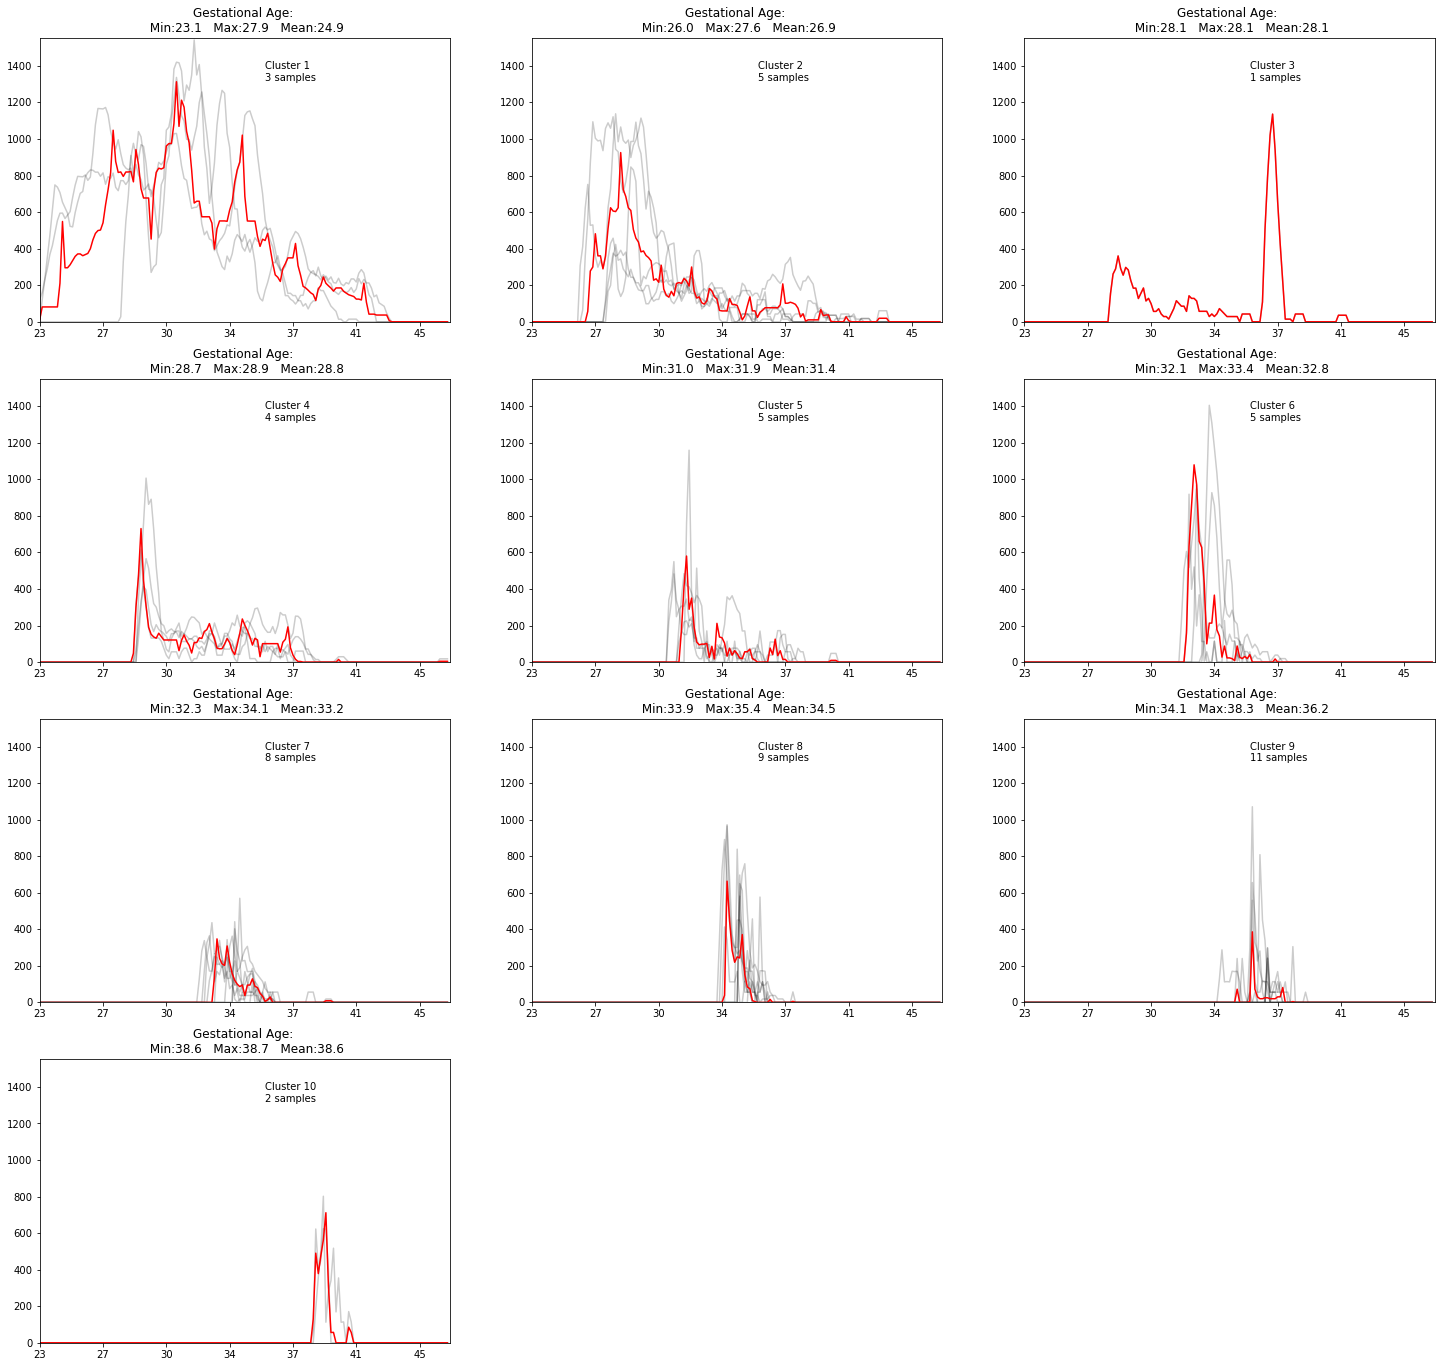

In [39]:
# plot each cluster in ascending order of mean GA
# all pain profiles are plotted in black. dtw barycenter average for each cluster plotted in red

# create list of dataframes of each cluster
clusters=[]
for i in range(clus_mean_ga_df.shape[0]):
    clusters.append(df_ma[clus_label_df.cluster==i+1])    
sz= df_ma.shape[1]
n_clus= 1
dba_km = TimeSeriesKMeans(n_clusters=n_clus,
                          n_init=3,
                          metric="dtw",
                          metric_params = {'sakoe_chiba_radius':7},
                          max_iter_barycenter=10,
                          random_state=13)
xticks= list(range(start_day, start_day+sz+1,25))
xticks_weeks= [int(np.round(x/7)) for x in xticks]
xrange= list(range(0,sz+1,25))
columns= 3
rows= 4
fig= plt.figure(figsize=(25,rows*6))

n_clusters= sum(n_cluss)
for c in range(n_clusters):
    y_pred = dba_km.fit_predict(clusters[c])
    ga_df_c= ga_df.loc[ga_df.index.isin(list(clusters[c].index))]
    ga_stats= ga_stats_gen(y_pred, n_clus, ga_df_c)
    ga_stats_week= np.round(ga_stats/7,1)
    fig.add_subplot(rows,columns,c+1)
    for j in np.array(clusters[c][y_pred==0]):
            plt.plot(np.array(range(len(j))),j, 'k-', alpha=.2)
    plt.plot(np.array(range(len(dba_km.cluster_centers_[0]))), dba_km.cluster_centers_[0], 'r-')
    plt.xlim(0,sz)
    plt.ylim(0,y_max+10)
    plt.xticks(xrange, xticks_weeks)
    plt.text(0.55, 0.85, 'Cluster %d \n%d samples' % ((c + 1), clusters[c][y_pred==0].shape[0]), transform=plt.gca().transAxes)
    plt.title( "Gestational Age: \n Min:%.1f   Max:%.1f   Mean:%.1f" %(ga_stats_week.min_ga[0], ga_stats_week.max_ga[0], ga_stats_week.mean_ga[0]),fontsize=12)

In [14]:
from tslearn.clustering import silhouette_score

In [15]:


# derive distan

In [16]:
# calculate silhouette score to evaluate clustering
sil_score_extreme= silhouette_score(extreme, labels=y_pred_extreme, metric='dtw', 
                                    metric_params = {'sakoe_chiba_radius':7}, random_state=13)
sil_score_very= silhouette_score(very, labels=y_pred_very, metric='dtw',
                                 metric_params = {'sakoe_chiba_radius':7}, random_state=13)
sil_score_moderate= silhouette_score(moderate, labels=y_pred_moderate, metric='dtw',
                                     metric_params = {'sakoe_chiba_radius':7}, random_state=13)
sil_score= (sil_score_extreme*extreme.shape[0] + sil_score_very*very.shape[0] + sil_score_moderate*moderate.shape[0])/df_ma.shape[0]
print('Average Silhouette score: %.2f' %np.round(sil_score,2))

Average Silhouette score: 0.37


In [17]:
sil_score_extreme

0.4983353176215761

In [18]:
sil_score_very

0.4527871418239188

In [19]:
sil_score_moderate

0.3164053159770779

In [20]:
from sklearn.metrics import silhouette_samples

In [21]:
from dtaidistance import dtw

In [22]:
dis_mat_extreme= dtw.distance_matrix(np.matrix(extreme), window=7)
dis_mat_very= dtw.distance_matrix(np.matrix(very), window=7)
dis_mat_moderate= dtw.distance_matrix(np.matrix(moderate), window=7)

In [23]:
sil_sam_extreme= silhouette_samples(dis_mat_extreme, labels= y_pred_extreme, metric= 'precomputed')
sil_sam_very= silhouette_samples(dis_mat_very, labels= y_pred_very, metric= 'precomputed')
sil_sam_moderate= silhouette_samples(dis_mat_moderate, labels= y_pred_moderate, metric= 'precomputed')

In [24]:
sil_ind= list(extreme.index) + list(very.index) + list(moderate.index)

In [25]:
sil_sam= list(np.concatenate((sil_sam_extreme, sil_sam_very, sil_sam_moderate)))

In [26]:
sil_df= pd.DataFrame(list(zip(sil_ind, sil_sam)), columns= ['id', 'silhouette_score'])
sil_df.set_index('id', inplace= True)
sil_df= sil_df.join(clus_label_df, on='id').drop(['ga_days', 'ga_weeks'], axis=1)

In [27]:
import matplotlib.cm as cm

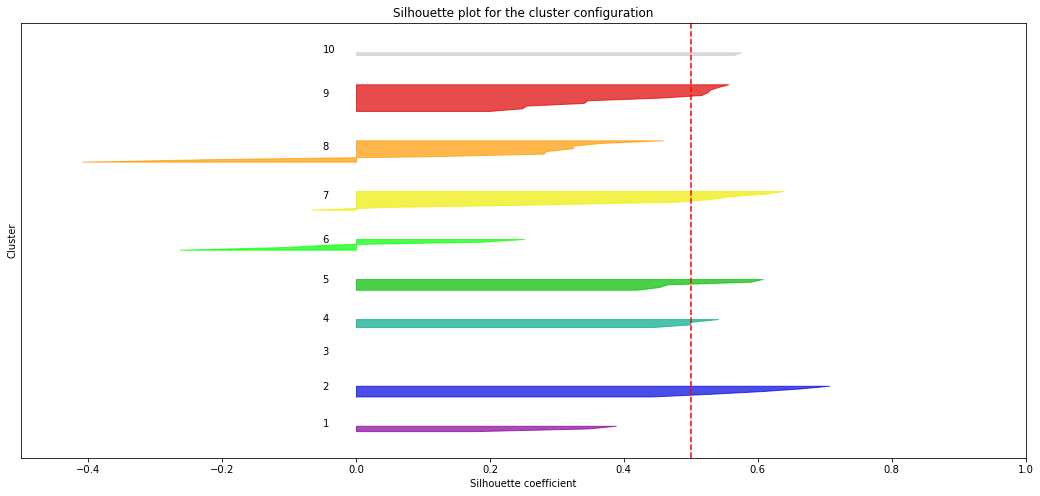

In [38]:
y_lower = 10
fig= plt.figure(figsize=(18,8))
for i in range(1, n_clusters+1):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = np.array(sil_df.silhouette_score[sil_df.cluster == i])

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    plt.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples
    
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.5, 1]
plt.xlim([-0.5, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
plt.ylim([0, sil_df.shape[0] + (n_clusters + 1) * 10])
plt.title("Silhouette plot for the cluster configuration")
plt.xlabel("Silhouette coefficient")
plt.ylabel("Cluster")

# The vertical line for benchmark silhouette score (0.5)
plt.axvline(x=0.5, color="red", linestyle="--")

plt.yticks([])  # Clear the yaxis labels / ticks
plt.xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

In [29]:
sil_df[sil_df.cluster==8]

,silhouette_score,cluster
id,,
CC00192AN12_64301,0.323401,8
CC00271XX08_100400,-0.408879,8
CC00569XX17_170600,0.324329,8
CC00648XX22_204400,0.458268,8
CC00797XX23_12110,0.279953,8
CC00845AN21_32010,0.365092,8
CC00845BN21_32110,0.284531,8
CC01011XX05_53531,-0.202843,8
CC00986BN22_41830,0.102005,8


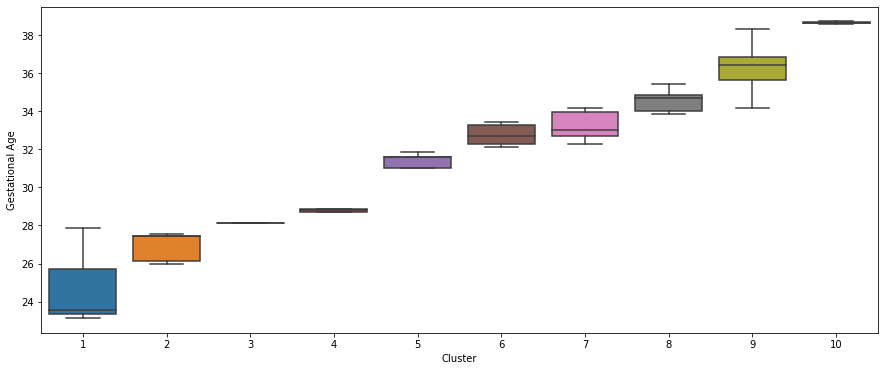

In [36]:
# boxplot to compare distribution of gestational age among clusters
# clusters ordered by mean gestational age
fig= plt.figure(figsize=(15,6))
sns.boxplot(x= 'cluster', y= 'ga_weeks', data= clus_label_df)
plt.ylabel('Gestational Age')
plt.xlabel('Cluster')
plt.show()

In [31]:
#clus_label_df.to_csv('clus_label.csv')

In [34]:
clus_label_df

,cluster,ga_days,ga_weeks
id,,,
CC00112XX05_37001,1,162,23.14
CC00946XX23_26330,1,165,23.57
CC00955XX15_39730,1,195,27.86
CC00526XX15_169900,2,182,26.00
CC00661XX10_209600,2,193,27.57
CC00518XX15_166600,2,183,26.14
CC00529AN18_170000,2,192,27.43
CC00529BN18_170100,2,192,27.43
CC00657XX14_212200,3,197,28.14
